It is an example of working with a custom regressor and classifier. Also, there is an example of matrix usage for training with CatBoost.

A data set I'm working with contains records about cafes, restaurants, and other facilities and their location, rating, average bill, categories, and features.

The purpose of the training will be to predict the average bill.

In [10]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [5]:
work_dir = os.getcwd()
base = work_dir + '/'

data = pd.read_csv(base + 'organisations.csv')
features = pd.read_csv(base + 'features.csv')
rubrics = pd.read_csv(base + 'rubrics.csv')

In [6]:
data.head()

,org_id,city,average_bill,rating,rubrics_id,features_id
0,15903868628669802651,msk,1500.0,4.270968,30776 30774,3501685156 3501779478 20422 3502045016 3502045...
1,16076540698036998306,msk,500.0,4.375000,30771,1509 1082283206 273469383 10462 11617 35017794...
2,8129364761615040323,msk,500.0,4.000000,31495,10462 11177 11617 11629 1416 1018 11704 11867 ...
3,15262729117594253452,msk,500.0,4.538813,30776 30770,3501618484 2020795524 11629 11617 1018 11704 2...
4,13418544315327784420,msk,500.0,4.409091,31495,11617 10462 11177 1416 11867 3501744275 20282 ...


### Data manipulation

In [7]:
rubric_dict = {}
for _, row in rubrics.iterrows():
    rubric_dict[row['rubric_id']] = row['rubric_name']
features_dict = {}
for _, row in features.iterrows():
    features_dict[row['feature_id']] = row['feature_name']

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68339 entries, 0 to 68338
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   org_id        68339 non-null  uint64 
 1   city          68339 non-null  object 
 2   average_bill  32778 non-null  float64
 3   rating        54608 non-null  float64
 4   rubrics_id    68339 non-null  object 
 5   features_id   57290 non-null  object 
dtypes: float64(2), object(3), uint64(1)
memory usage: 3.1+ MB


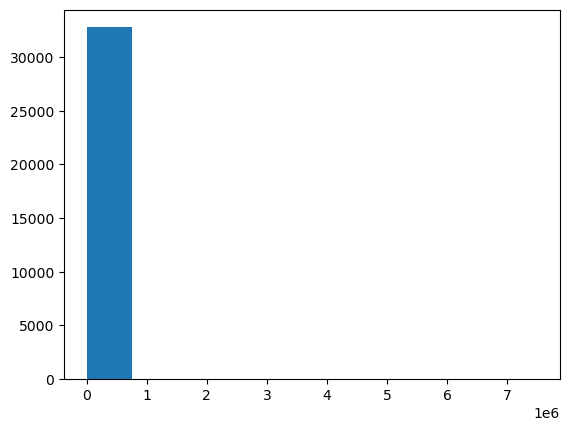

In [11]:
plt.hist(data['average_bill'])
plt.show()

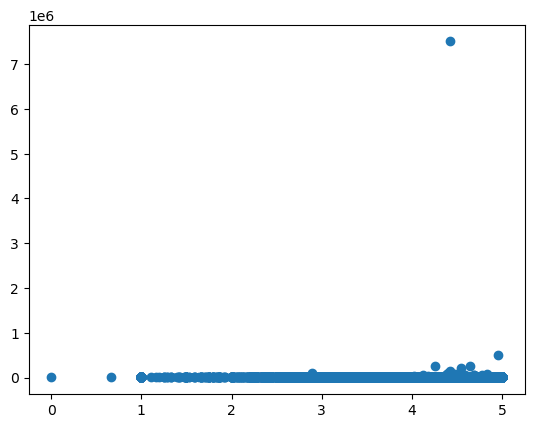

In [12]:
plt.scatter(data['rating'], data['average_bill'])
plt.show()

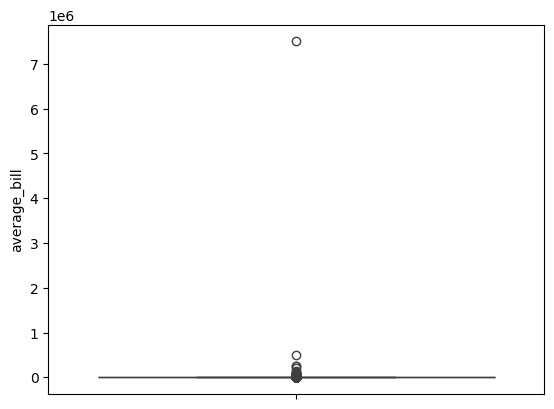

In [13]:
sns.boxplot(data['average_bill'])
plt.show()

I'll remove the records with the average bill over 2500.

In [16]:
data_cleaned = data[~((data['average_bill'].isna()) | (data['average_bill'] > 2500))]
data_cleaned

,org_id,city,average_bill,rating,rubrics_id,features_id
0,15903868628669802651,msk,1500.0,4.270968,30776 30774,3501685156 3501779478 20422 3502045016 3502045...
1,16076540698036998306,msk,500.0,4.375000,30771,1509 1082283206 273469383 10462 11617 35017794...
2,8129364761615040323,msk,500.0,4.000000,31495,10462 11177 11617 11629 1416 1018 11704 11867 ...
3,15262729117594253452,msk,500.0,4.538813,30776 30770,3501618484 2020795524 11629 11617 1018 11704 2...
4,13418544315327784420,msk,500.0,4.409091,31495,11617 10462 11177 1416 11867 3501744275 20282 ...
...,...,...,...,...,...,...
68328,17662684569129497551,spb,1000.0,4.561707,30776,246 3501779478 1018 3501618484 3501481353 3501...
68329,5700899951016592061,msk,1500.0,4.377129,31401,3501773763 10462 1018 246 3501779478 350175479...
68330,4686040819909966338,msk,1500.0,3.666667,30776,10462 1189498238 11629 1416 1415 11741 3501481...
68331,12499715465202129892,msk,1500.0,4.554577,30770 30776 30774,273469383 10462 21247 1509 1416 3501618484 350...


### Custom Regressor and Classificator

In [25]:
clean_data_train, clean_data_test = train_test_split(
    data_cleaned, stratify=data_cleaned['average_bill'], test_size=0.33, random_state=42)

In [47]:
from scipy.stats import mode
from sklearn.base import RegressorMixin
from sklearn.base import ClassifierMixin
import statistics
from warnings import simplefilter
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

**There are two models:**
* Regression model, which calculates the mean average bill among all the records.
* Classification model, which predicts the one class - the most repeated one.

In [39]:
class MeanRegressor(RegressorMixin):
    # Predicts the mean of y_train
    def fit(self, X=None, y=None):
        self.y = np.mean(y)
        self.is_fitted_ = True
        return self

    def predict(self, X=None):
        return pd.Series([self.y] * len(X), index=X.index)

class MostFrequentClassifier(ClassifierMixin):
    def __init__(self):
        simplefilter(action='ignore', category=FutureWarning)
    # Predicts the rounded (just in case) median of y_train
    def fit(self, X=None, y=None): 
        d = {}
        for i in y:
            if i not in d:
                d[i] = 1
            else:
                d[i] = d[i] + 1
        self.classes_ = max(d, key=d.get)
        return self

    def predict(self, X=None):
        return pd.Series([self.classes_] * len(X), index=X.index)

In [40]:
reg = MeanRegressor()
reg.fit(y=clean_data_train['average_bill'])

clf = MostFrequentClassifier()
clf.fit(y=clean_data_train['average_bill'])

In [41]:
y_reg_pred = reg.predict(clean_data_test)
y_clf_pred = clf.predict(clean_data_test)

In [42]:
# а вот для классификационной можно найти обе метрики. Сделайте это. Какая модель оказалась лучше по RMSE?
rmse_reg = np.sqrt(mean_squared_error(clean_data_test['average_bill'], y_reg_pred))

rmse_clf = np.sqrt(mean_squared_error(clean_data_test['average_bill'], y_clf_pred))
bas_clf = balanced_accuracy_score(clean_data_test['average_bill'], y_clf_pred)

print(f"For regression model:\nRMSE: {rmse_reg}\n")
print(f"For classification model:\nRMSE: {rmse_clf}; Balanced accuracy score: {bas_clf}")

For regression model:
RMSE: 448.7143889551622

For classification model:
RMSE: 514.7517402382093; Balanced accuracy score: 0.2


______________________________________________________
**More complicated model, which calculates the mean value for the city:**

In [44]:
class CityMeanRegressor(RegressorMixin):
    def fit(self, X=None, y=None):
        city_list = X['city']
        self.sity_means_ = pd.DataFrame({
            'city': city_list,
            'y': y
        }).groupby('city')['y'].mean().to_dict()
        return self

    def predict(self, X=None):
        return X['city'].map(self.sity_means_).values

In [46]:
X_train = clean_data_train.drop(['average_bill'], axis = 1)
y_train = clean_data_train['average_bill']
X_test = clean_data_test.drop(['average_bill'], axis = 1)
y_test = clean_data_test['average_bill']

model_city = CityMeanRegressor()
model_city.fit(X_train, y_train)

In [48]:
y_pred = model_city.predict(X_test)

In [49]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

MAE: 345.30
RMSE: 445.11
R²: 0.02


-----
**The next model calculates the median value of the average bill based on rubrics and city**

But before, I'll create a new column in which will be the modified rubrics: it will be the current rubric or the value 'other' if the combination occurs in the dataset less than 100 times.

In [53]:
from collections import Counter

In [54]:
c = Counter(X_train['rubrics_id'])
X_train['modified_rubrics'] = X_train['rubrics_id'].apply(
    lambda x: x if c[x] >= 100 else 'other'
)
X_test['modified_rubrics'] = X_test['rubrics_id'].apply(
    lambda x: x if c[x] >= 100 else 'other'
)
X_test.head()

,org_id,city,rating,rubrics_id,features_id,modified_rubrics
65841,14385912302763770021,spb,4.748444,30776 30770 31401,11177 3501618484 10462 3501481355 1509 1416 20...,other
48882,16695436192794975203,msk,3.793758,30771,3501744275 273469383 3501513153 11617 10462 11...,30771
33711,11841431940065207518,msk,3.606557,30771 30777,3501773763 3501744275 3501773764 3501618484 15...,other
33544,16028521499441205186,msk,4.683841,30776,3501618484 20422 1082283206 11704 11629 21247 ...,30776
35293,12477116204055673498,spb,4.165394,30776 31401 30770,1524 246 11704 1018 3501618484 2020795524 2124...,other


In [55]:
class RubricCityMedianClassifier(ClassifierMixin):
    def __init__(self):
        simplefilter(action='ignore', category=FutureWarning)
    def fit(self, X=None, y=None):

        test = X
        test['y'] = y
        test_dict = {}
        result_dict = {}
        for item in test['city'].unique():
            test_dict[item] = test[test['city'] == item]

        for index in test_dict:
            result_dict[index] = test_dict[index].groupby(['modified_rubrics'])['y'].apply(
                lambda x: statistics.median(x)
            ).to_dict()
            
        self.classes_ = result_dict
        return self

    def predict(self, X=None):
        return X.apply(lambda x: (self.classes_[x['city']][x['modified_rubrics']]), axis=1)

In [56]:
model_rubric_city = RubricCityMedianClassifier()
model_rubric_city.fit(X_train, y_train)

In [57]:
y_pred = model_rubric_city.predict(X_test)

In [58]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
score = balanced_accuracy_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")
print(f"balanced_accuracy_score: {score:.2f}")

MAE: 193.02
RMSE: 393.97
R²: 0.23
balanced_accuracy_score: 0.31


-----
**This next model calculates the median value of the average bill based on rubrics and features**

For this I'll create a modified feature column which contains rubrics and feature

In [59]:
def get_modified_features(feature):
    if feature in feature_set:
        return feature
    else:
        return "other"

X_train['modified_features'] = X_train['rubrics_id'] + "_" + X_train['features_id']

feature_set = set(X_train['modified_features'])

X_test['modified_features'] = X_test.apply(
    lambda x: get_modified_features(x['rubrics_id'] + "_" + x['features_id']), 
    axis = 1
)
X_train.head()

,org_id,city,rating,rubrics_id,features_id,modified_rubrics,y,modified_features
45769,3276960721840719260,msk,4.500000,30770,11704 20422 1018 11177 1416 11867 10462,30770,500.0,30770_11704 20422 1018 11177 1416 11867 10462
39061,8452997364765928283,msk,4.442623,30774 30776,1415 3501481355 1416 11629 10462 1524 20422 11...,30774 30776,1500.0,30774 30776_1415 3501481355 1416 11629 10462 1...
59281,14240408259222214074,spb,4.018868,30776 30774,3502045032 11741 3502045016 10462 11704 350177...,30776 30774,1000.0,30776 30774_3502045032 11741 3502045016 10462 ...
51225,15114069072602161053,msk,4.364742,31401 30776,3501513153 3501779478 3491142672 273469383 350...,other,1500.0,31401 30776_3501513153 3501779478 3491142672 2...
29587,2730337118800634815,msk,4.698718,30770,21247 10896 3491142672 11629 3501481353 350148...,30770,1000.0,30770_21247 10896 3491142672 11629 3501481353 ...


In [62]:
class FeatureMedianClassifier(ClassifierMixin):
    
    def fit(self, X=None, y=None):
        self.medians_: dict = (
            X.assign(target=y).groupby('modified_features')
            ['target'].median().to_dict()  # Faster lookup than pandas series
        )
        self.medians_['other'] = y.median()

        return self

    def predict(self, X=None):
        return X['modified_features'].map(self.medians_)

In [63]:
model_features = FeatureMedianClassifier()
model_features.fit(X_train, y_train)
y_pred = model_features.predict(X_test)

In [65]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
score = balanced_accuracy_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"balanced_accuracy_score: {score:.2f}")

RMSE: 513.99
balanced_accuracy_score: 0.20


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


### CatBoost and sparse matrix

For the CatBoost usage, I'll create columns for each rubric and feature from the train set, also I'll change the city columns' values: it will be 1 for 'msk' and 0 for 'spb'. After that, I'll create a COO matrix, which will be transformed into a CSR matrix.
But before that I'll fill the missing values for rating

In [67]:
cleaned_data_withon_nan = data_cleaned
mean_rating = data_cleaned[~data_cleaned['rating'].isna()][['rating']].mean()
cleaned_data_withon_nan['rating'] = np.where(cleaned_data_withon_nan['rating'].isna(), mean_rating, cleaned_data_withon_nan['rating'])
cleaned_data_withon_nan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32136 entries, 0 to 68332
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   org_id        32136 non-null  uint64 
 1   city          32136 non-null  object 
 2   average_bill  32136 non-null  float64
 3   rating        32136 non-null  float64
 4   rubrics_id    32136 non-null  object 
 5   features_id   32136 non-null  object 
dtypes: float64(2), object(3), uint64(1)
memory usage: 1.7+ MB


/var/folders/1t/qjkxb95n6t340fwg3jkd9ltm0000gn/T/ipykernel_70675/3401320765.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data_withon_nan['rating'] = np.where(cleaned_data_withon_nan['rating'].isna(), mean_rating, cleaned_data_withon_nan['rating'])


In [68]:
clean_data_train, clean_data_test = train_test_split(
    cleaned_data_withon_nan, stratify=cleaned_data_withon_nan['average_bill'], test_size=0.33, random_state=42)
clean_data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21531 entries, 45769 to 17863
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   org_id        21531 non-null  uint64 
 1   city          21531 non-null  object 
 2   average_bill  21531 non-null  float64
 3   rating        21531 non-null  float64
 4   rubrics_id    21531 non-null  object 
 5   features_id   21531 non-null  object 
dtypes: float64(2), object(3), uint64(1)
memory usage: 1.1+ MB


In [69]:
clean_data_train['city'] = np.where(clean_data_train['city'] == 'msk', 1, 0)
clean_data_test['city'] = np.where(clean_data_test['city'] == 'msk', 1, 0)
clean_data_train.head()

,org_id,city,average_bill,rating,rubrics_id,features_id
45769,3276960721840719260,1,500.0,4.500000,30770,11704 20422 1018 11177 1416 11867 10462
39061,8452997364765928283,1,1500.0,4.442623,30774 30776,1415 3501481355 1416 11629 10462 1524 20422 11...
59281,14240408259222214074,0,1000.0,4.018868,30776 30774,3502045032 11741 3502045016 10462 11704 350177...
51225,15114069072602161053,1,1500.0,4.364742,31401 30776,3501513153 3501779478 3491142672 273469383 350...
29587,2730337118800634815,1,1000.0,4.698718,30770,21247 10896 3491142672 11629 3501481353 350148...


In [70]:
def get_unique_ids(series):
    return set(id_ for row in series for id_ in row.split())
    
# all unique rubrics and features from train
rubric_vocab = sorted(get_unique_ids(clean_data_train['rubrics_id']))
feature_vocab = sorted(get_unique_ids(clean_data_train['features_id']))

# create dictinaries: rubric -> column index
rubric_to_col = {rid: i for i, rid in enumerate(rubric_vocab)}
feature_to_col = {fid: i for i, fid in enumerate(feature_vocab)}

In [72]:
feature_names = ['rating', 'city']  

# add pubrics and features in the matrix's order
feature_names += [f"rubric_{rid}" for rid in rubric_vocab]
feature_names += [f"feature_{fid}" for fid in feature_vocab]

# the column for features from a test dataset, which didn't occur in the train
feature_names.append('feature_other')

In [73]:
rubric_to_col = {rid: i + 2 for i, rid in enumerate(rubric_vocab)}  # +2 из-за city и rating
feature_to_col = {fid: i + 2 + len(rubric_vocab) for i, fid in enumerate(feature_vocab)}
feature_to_col["feature_other"] = 2 + len(rubric_vocab) + len(feature_vocab)

n_cols = 2 + len(rubric_vocab) + len(feature_vocab) + 1

In [74]:
from scipy.sparse import coo_matrix

In [75]:
def build_sparse_matrix(df, rubric_to_col, feature_to_col, n_cols):
    row = []
    col = []
    data = []
    n_objects = df.shape[0]

    for i, row_data in enumerate(df.itertuples(index=False)):
        # city (0 or 1)
        row.append(i)
        col.append(0)
        data.append(row_data.city)

        # rating (the second column)
        row.append(i)
        col.append(1)
        data.append(row_data.rating)

        # rubrics
        for rid in row_data.rubrics_id.split():
            if rid in rubric_to_col:
                row.append(i)
                col.append(rubric_to_col[rid])
                data.append(1)

        # features
        unknown_feature_count = 0
        for fid in row_data.features_id.split():
            if fid in feature_to_col:
                row.append(i)
                col.append(feature_to_col[fid])
                data.append(1)
            else:
                unknown_feature_count += 1

        # feature_other — the number of unknown features
        if "feature_other" in feature_to_col:
            row.append(i)
            col.append(feature_to_col["feature_other"])
            data.append(unknown_feature_count)

    # build a COO-матрицу, and then transform into CSR
    sparse = coo_matrix((data, (row, col)), shape=(n_objects, n_cols)).tocsr()
    return sparse

In [76]:
sparse_data_train = build_sparse_matrix(clean_data_train, rubric_to_col, feature_to_col, n_cols)
sparse_data_test = build_sparse_matrix(clean_data_test, rubric_to_col, feature_to_col, n_cols)

In [77]:
from catboost import CatBoostClassifier

In [78]:
clf = CatBoostClassifier()
clf.fit(sparse_data_train, clean_data_train['average_bill'])

Learning rate set to 0.092536
0:	learn: 1.4298912	total: 93.9ms	remaining: 1m 33s
1:	learn: 1.3117349	total: 118ms	remaining: 58.9s
2:	learn: 1.2254349	total: 141ms	remaining: 47s
3:	learn: 1.1489528	total: 167ms	remaining: 41.6s
4:	learn: 1.0905690	total: 201ms	remaining: 39.9s
5:	learn: 1.0406406	total: 230ms	remaining: 38.1s
6:	learn: 1.0006546	total: 255ms	remaining: 36.1s
7:	learn: 0.9648913	total: 279ms	remaining: 34.6s
8:	learn: 0.9350792	total: 305ms	remaining: 33.5s
9:	learn: 0.9073672	total: 329ms	remaining: 32.6s
10:	learn: 0.8856449	total: 353ms	remaining: 31.8s
11:	learn: 0.8656296	total: 378ms	remaining: 31.1s
12:	learn: 0.8464786	total: 404ms	remaining: 30.6s
13:	learn: 0.8316937	total: 430ms	remaining: 30.3s
14:	learn: 0.8187064	total: 460ms	remaining: 30.2s
15:	learn: 0.8050988	total: 482ms	remaining: 29.7s
16:	learn: 0.7930401	total: 508ms	remaining: 29.4s
17:	learn: 0.7818719	total: 533ms	remaining: 29.1s
18:	learn: 0.7733504	total: 558ms	remaining: 28.8s
19:	learn: 

In [79]:
y_pred = clf.predict(sparse_data_test)

In [80]:
bas = balanced_accuracy_score(clean_data_test['average_bill'], y_pred)
bas

0.35498588639726775